<a href="https://colab.research.google.com/github/asminimulin/cv-course/blob/main/02-image-linear-classification/Linear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset with Pytorch



## Load the data

In [ ]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image


# Define transformation for each image
transform  = transforms.Compose([
    # transforms.Grayscale(1),
    # transforms.to
    transforms.Lambda(lambda x: np.array(x).flatten()) #Stretch image into row [32,32,3] -> [3072]
])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("/content",
                           train=True,
                           transform = transform,
                           download=True)


Files already downloaded and verified


## Split dataset & define dataloaders

torch.Size([256, 3072]) torch.Size([256])


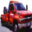

9

In [ ]:
train_ds, val_ds, _= random_split(dataset, [20000,1000 ,29000])
# Hint: Perform debug on smaller subset

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)

# Display one image
for images, class_nums in train_loader:
  print (images.shape,class_nums.shape) # class_nums are tensor!
  display(Image.fromarray(images[0].reshape((32,32,3)).numpy()),class_nums[0].item()) 
  break 


# Implement LinearClassifier class for CIFAR10

In [ ]:
class LinearClassifier:
  def __init__(self, labels, ):
    self.labels = labels
    self.classes_num = len(labels)
    # Generate a random weight matrix of small numbers
    # You can change this code
    self.W = np.random.randn(3072, self.classes_num) * 0.0001 
    self.batch_size = 200

  
  def train(self, x_batch, y_batch, learning_rate = 1e-8):
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """
    
    loss_val, grad = self.loss(x_batch, y_batch)

    # Update weights (self.W)

    return loss/x_batch.shape[0]

  def loss(self,x, y): # x and y are batches
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """

    loss = 0.0
    dW = np.zeros(self.W.shape)

    # Calculate Multiclass SVM or Cross-entropy loss over a batch 

    # Calculate gradients (dL/dW) and store it in dW

    return loss, dW
      
  def predict(self,x):
    x = self.add_ones(x)
    scores = x.dot(self.W) # (256, 3073) * (3073, 10)
    return np.argmax(scores,axis = 1)


# Train model

## Function for accuracy checking

Don't change this code

In [ ]:
from sklearn.metrics import accuracy_score

def validate(model,dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted,index) 
    y_gtrue = np.append(y_gtrue,class_nums.numpy()) 
  return accuracy_score(y_gtrue, y_predicted)  

## Train loop
Let's train our model

In [ ]:

model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

# Check model on test dataset

You must get accuracy above 0.35


In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


# Place for brief conclusion
Feel free to describe troubles here.


...



# Ideas for extra work

- Implenment CrossEntropyLoss function
- Implement bias trick
- Add regularization to SVM loss
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data


 